In [121]:
import sklearn
import sklearn.preprocessing     # For StandardScaler
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6)

### Dataset Cleaning and reformat

In [122]:
data = pd.read_csv('data/PRSA_data_2010.1.1-2014.12.31.csv')

In [123]:
data["timestamp"] = pd.to_datetime(data[["year", "month", "day", "hour"]])

In [124]:
data = data.set_index("timestamp")

In [125]:
data.drop(["No", "year", "month", "day", "hour"], axis=1, inplace=True)

In [126]:
data

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [127]:
# Drop NAN value
data = data.dropna()

In [128]:
data

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [113]:
# Factorize String data
data['cbwd'] = pd.factorize(data['cbwd'])[0]

/Users/rickytechnip/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [114]:
data.to_csv('data/cleaned_data')

In [115]:
data

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,0,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,0,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,0,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,0,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,0,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,2,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,2,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,2,242.70,0,0


In [116]:
data.columns

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')

### Dataset Visualization

Text(0.5, 1.0, 'PM2.5 with timestamp')

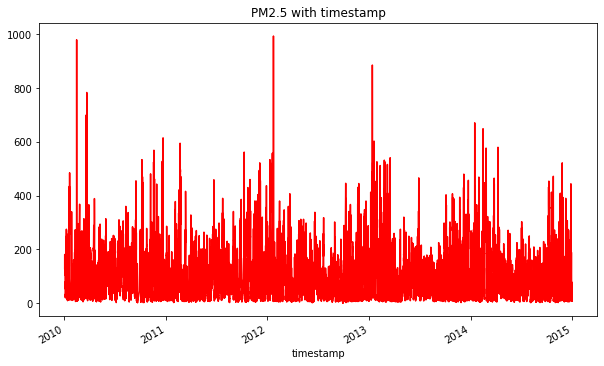

In [117]:
data['pm2.5'].plot(kind='line',color='red')
plt.title("PM2.5 with timestamp")

Text(0.5, 1.0, 'Cumulated Hours Of Rnow Distribution')

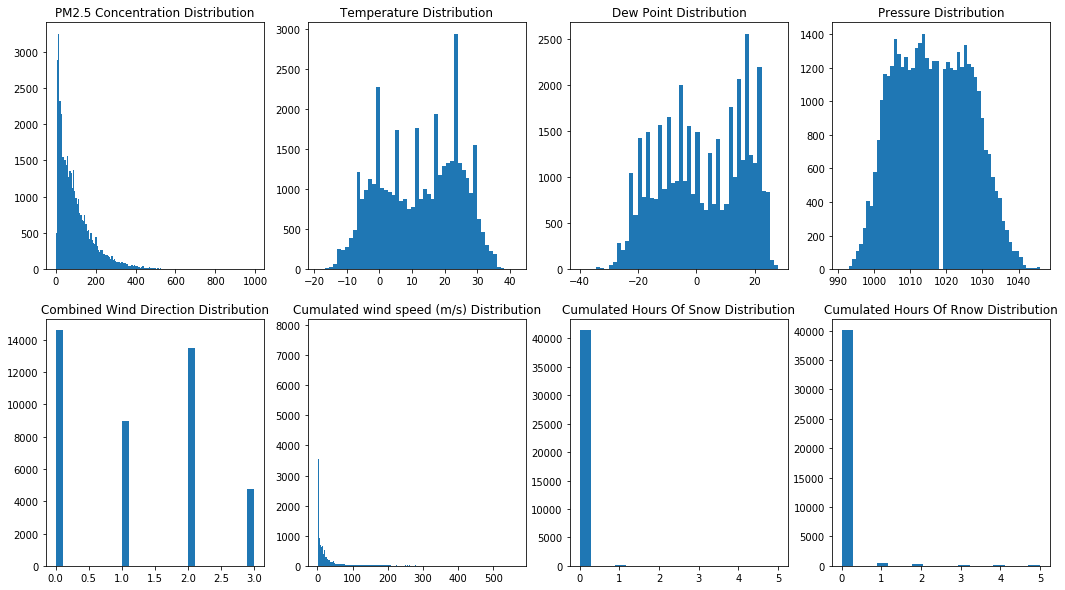

In [118]:
plt.figure(figsize=(18,10))
plt.subplot(2, 4, 1)
plt.hist(data['pm2.5'], bins='auto')
plt.title('PM2.5 Concentration Distribution')
plt.subplot(2, 4, 2)
plt.hist(data['TEMP'], bins='auto')
plt.title('Temperature Distribution')
plt.subplot(2, 4, 3)
plt.hist(data['DEWP'], bins='auto')
plt.title('Dew Point Distribution')
plt.subplot(2, 4, 4)
plt.hist(data['PRES'], bins='auto')
plt.title('Pressure Distribution')
plt.subplot(2, 4, 5)
plt.hist(data['cbwd'], bins='auto')
plt.title('Combined Wind Direction Distribution')
plt.subplot(2, 4, 6)
plt.hist(data['Iws'], bins='auto')
plt.title('Cumulated wind speed (m/s) Distribution')
plt.subplot(2, 4, 7)
plt.hist(data['Is'], bins='auto', range=[0,5])
plt.title('Cumulated Hours Of Snow Distribution')
plt.subplot(2, 4, 8)
plt.hist(data['Ir'], bins='auto', range=[0,5])
plt.title('Cumulated Hours Of Rnow Distribution')

In [119]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

In [120]:
encode_numeric_zscore(newdata, 'pm2.5')
encode_numeric_zscore(newdata, 'TEMP')
encode_numeric_zscore(newdata, 'DEWP')
encode_numeric_zscore(newdata, 'PRES')
encode_numeric_zscore(newdata, 'cbwd')
encode_numeric_zscore(newdata, 'Iws')
encode_numeric_zscore(newdata, 'Is')
encode_numeric_zscore(newdata, 'Ir')

KeyError: 'pm2.5'

In [61]:
df_normal = newdata.iloc[:30000, :]

In [62]:
X_normal = df_normal.values

In [64]:
from sklearn.model_selection import train_test_split

x_normal_train, x_normal_test = train_test_split(
    X_normal, test_size=0.25, random_state=0)

In [68]:
from sklearn import metrics
import numpy as np
import pandas as pd
from IPython.display import display, HTML 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(5, input_dim=X_normal.shape[1], activation='relu'))
model.add(Dense(3, activation='relu')) # size to compress to
model.add(Dense(5, activation='relu'))
model.add(Dense(X_normal.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_normal_train,x_normal_train,verbose=1,epochs=200)

Train on 22500 samples
Epoch 1/200
22500/22500 [==============================] - 2s 100us/sample - loss: 0.8539
Epoch 2/200
22500/22500 [==============================] - 1s 63us/sample - loss: 0.5748
Epoch 3/200
22500/22500 [==============================] - 2s 67us/sample - loss: 0.4293
Epoch 4/200
22500/22500 [==============================] - 1s 64us/sample - loss: 0.2604
Epoch 5/200
22500/22500 [==============================] - 1s 59us/sample - loss: 0.2214
Epoch 6/200
22500/22500 [==============================] - 1s 62us/sample - loss: 0.2028
Epoch 7/200
22500/22500 [==============================] - 1s 58us/sample - loss: 0.1948
Epoch 8/200
22500/22500 [==============================] - 1s 63us/sample - loss: 0.1900
Epoch 9/200
22500/22500 [==============================] - 1s 57us/sample - loss: 0.1870
Epoch 10/200
22500/22500 [==============================] - 1s 58us/sample - loss: 0.1818
Epoch 11/200
22500/22500 [==============================] - 1s 58us/sample - loss: 0.

22500/22500 [==============================] - 1s 61us/sample - loss: 0.0606
Epoch 92/200
22500/22500 [==============================] - 1s 61us/sample - loss: 0.0603
Epoch 93/200
22500/22500 [==============================] - 1s 60us/sample - loss: 0.0603
Epoch 94/200
22500/22500 [==============================] - 1s 59us/sample - loss: 0.0604
Epoch 95/200
22500/22500 [==============================] - 1s 64us/sample - loss: 0.0605
Epoch 96/200
22500/22500 [==============================] - 1s 61us/sample - loss: 0.0604
Epoch 97/200
22500/22500 [==============================] - 1s 61us/sample - loss: 0.0608
Epoch 98/200
22500/22500 [==============================] - 1s 61us/sample - loss: 0.0603
Epoch 99/200
22500/22500 [==============================] - 1s 58us/sample - loss: 0.0605
Epoch 100/200
22500/22500 [==============================] - 1s 60us/sample - loss: 0.0604
Epoch 101/200
22500/22500 [==============================] - 1s 61us/sample - loss: 0.0604
Epoch 102/200
22500/2

22500/22500 [==============================] - 1s 62us/sample - loss: 0.0605
Epoch 182/200
22500/22500 [==============================] - 1s 58us/sample - loss: 0.0602
Epoch 183/200
22500/22500 [==============================] - 1s 63us/sample - loss: 0.0606
Epoch 184/200
22500/22500 [==============================] - 1s 61us/sample - loss: 0.0601
Epoch 185/200
22500/22500 [==============================] - 1s 63us/sample - loss: 0.0604
Epoch 186/200
22500/22500 [==============================] - 1s 59us/sample - loss: 0.0602
Epoch 187/200
22500/22500 [==============================] - 1s 58us/sample - loss: 0.0602
Epoch 188/200
22500/22500 [==============================] - 1s 59us/sample - loss: 0.0611
Epoch 189/200
22500/22500 [==============================] - 1s 60us/sample - loss: 0.0602
Epoch 190/200
22500/22500 [==============================] - 1s 65us/sample - loss: 0.0604
Epoch 191/200
22500/22500 [==============================] - 1s 66us/sample - loss: 0.0607
Epoch 192/200

In [80]:
pred = model.predict(x_normal_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,x_normal_test))
# pred = model.predict(X_normal)
# score2 = np.sqrt(metrics.mean_squared_error(pred,X_normal))


# print(f"Out of Sample Normal Score (RMSE): {score1}")
# print(f"Insample Normal Score (RMSE): {score2}")


In [82]:
pred[0]

array([-1.024861  , -1.2131696 ,  1.1249099 , -0.18746078, -0.36317134,
       -0.07202102, -0.13624215], dtype=float32)

In [83]:
x_normal_test[0]

array([-1.36834151, -0.93645666,  1.12196916, -0.19348858, -0.42700155,
       -0.07105638, -0.13740677])

In [84]:
pred.shape

(7500, 7)

In [87]:
error = metrics.mean_squared_error(pred[1],x_normal_test[1])

In [88]:
error

0.07044190419172858